In [23]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras 
from tensorflow.python.keras.layers import Input, Dense,LSTM,GRU
from tensorflow.python.keras.models import Sequential
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [24]:
df = pd.read_excel('oil_date.xlsx')
df.head()

,date,oil
0,2021-06-24,0.19
1,2021-06-25,0.57
2,2021-06-26,1.03
3,2021-06-27,1.38
4,2021-06-28,1.42


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 633 entries, 0 to 632
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    633 non-null    datetime64[ns]
 1   oil     633 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 10.0 KB


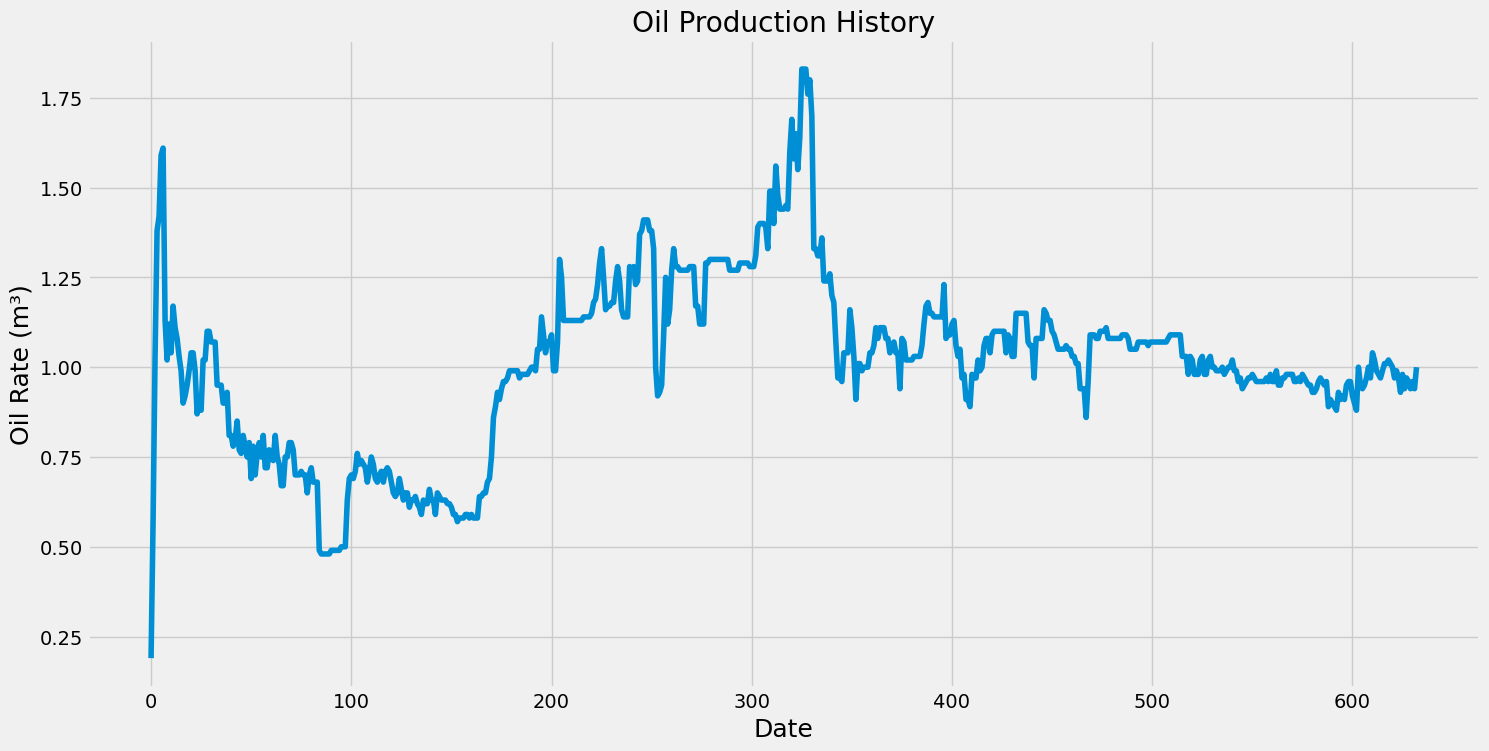

In [26]:
plt.figure(figsize=(16,8))
plt.title('Oil Production History')
plt.plot(df['oil'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Oil Rate (m³)',fontsize=18)
plt.show()

In [27]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['oil'])
#Converting the dataframe to a numpy array
dataset = data.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8) 

In [28]:
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [29]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train = []
y_train = []
for i in range(100,len(train_data)):
    x_train.append(train_data[i-100:i,0])
    y_train.append(train_data[i,0])

In [30]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [31]:
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [32]:
#Build the LSTM network model
#to have two LSTM layers with 50 neurons and two Dense layers, one with 25 neurons and the other with 1 neuron.
model = Sequential()
model.add(LSTM(units=64, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dense(units=32))
model.add(Dense(units=1))
optimizer = keras.optimizers.Adam(learning_rate = 0.0007007754058308959,decay=0.9242461402242185)

In [33]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [34]:
#Train the model
history=model.fit(x_train, y_train, batch_size=15, epochs=50,validation_split=0.25)

Epoch 1/50
21/21 [==============================] - 15s 364ms/step - loss: 0.0563 - val_loss: 0.0043
Epoch 2/50
21/21 [==============================] - 6s 275ms/step - loss: 0.0081 - val_loss: 0.0018
Epoch 3/50
21/21 [==============================] - 5s 216ms/step - loss: 0.0055 - val_loss: 0.0015
Epoch 4/50
21/21 [==============================] - 4s 214ms/step - loss: 0.0047 - val_loss: 0.0013
Epoch 5/50
21/21 [==============================] - 5s 215ms/step - loss: 0.0047 - val_loss: 0.0018
Epoch 6/50
21/21 [==============================] - 4s 213ms/step - loss: 0.0048 - val_loss: 0.0013
Epoch 7/50
21/21 [==============================] - 5s 217ms/step - loss: 0.0042 - val_loss: 0.0013
Epoch 8/50
21/21 [==============================] - 5s 217ms/step - loss: 0.0041 - val_loss: 0.0015
Epoch 9/50
21/21 [==============================] - 5s 223ms/step - loss: 0.0048 - val_loss: 0.0016
Epoch 10/50
21/21 [==============================] - 4s 210ms/step - loss: 0.0041 - val_loss: 0.002

In [35]:
def plot_metric(history,metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()
    return train_metrics, val_metrics

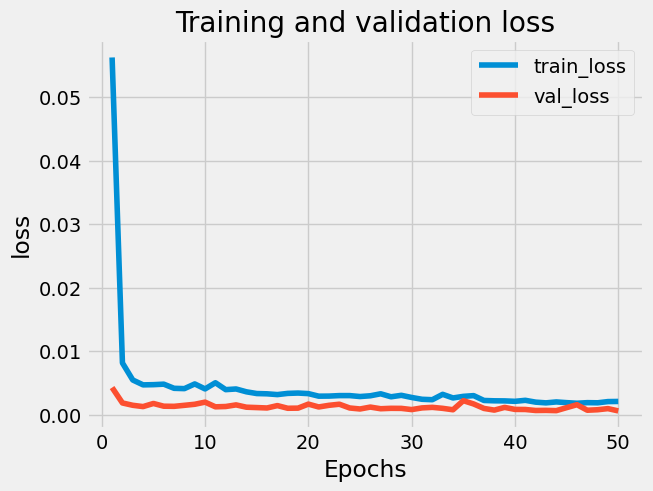

In [36]:
a,b=plot_metric(history, 'loss')

In [37]:
#Test data set
test_data = scaled_data[training_data_len - 100: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] 
for i in range(100,len(test_data)):
    x_test.append(test_data[i-100:i,0])

In [38]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [39]:
#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling

In [40]:
#Calculate/Get the value of RMSE(数值越低越好)
#np.dot(np.ones([116, 1]), np.ones([126, 1])).shape
rmse=np.sqrt(np.mean(((predictions - y_test)**2)))
rmse

0.026412764526643203

In [41]:
mse = np.mean(((predictions - y_test)**2))
mse

0.0006976341299399015

C:\Users\15966\AppData\Local\Temp\ipykernel_14856\473666728.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


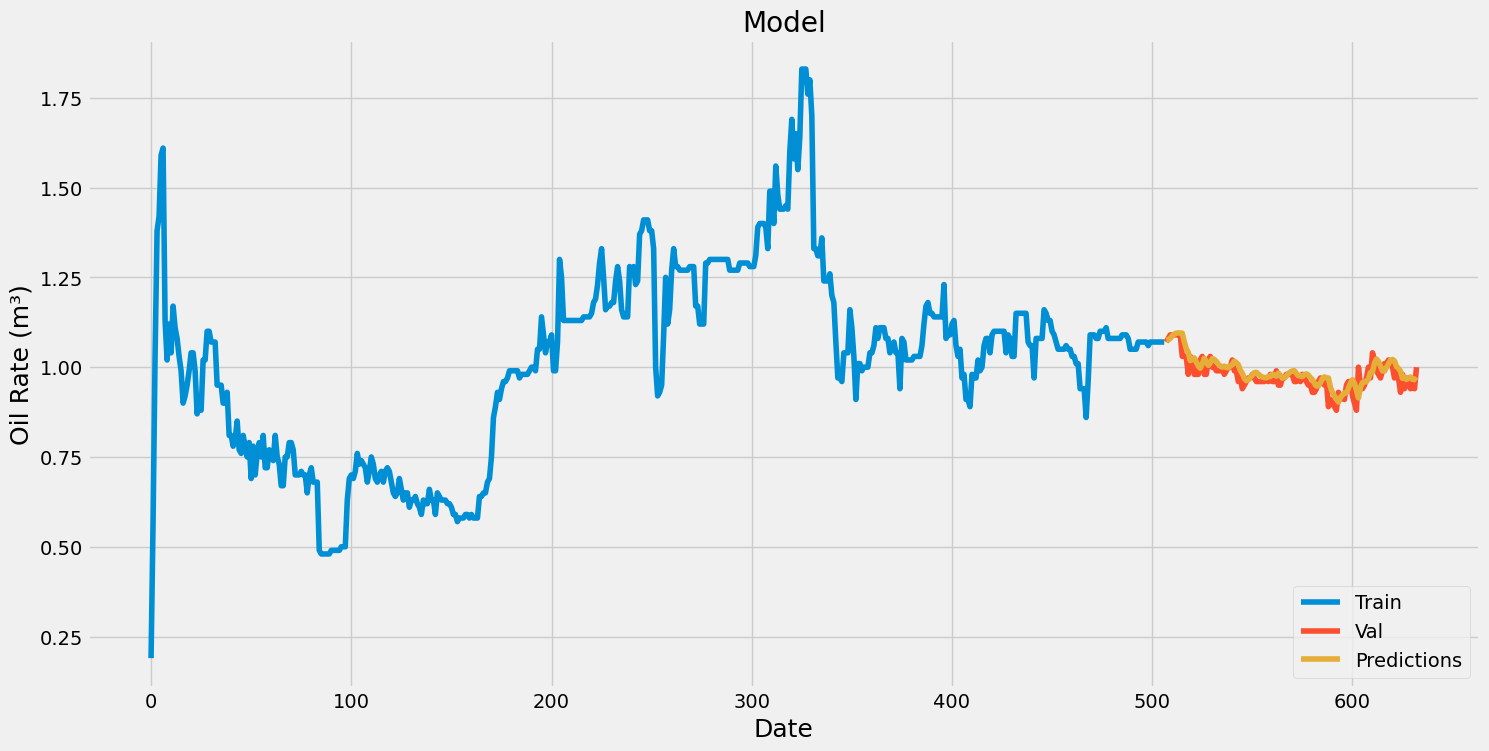

In [42]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Oil Rate (m³)', fontsize=18)
plt.plot(train['oil'])
plt.plot(valid[['oil', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')

plt.show()
output3 = pd.DataFrame(train)
output3.to_csv('train.csv', index = None, encoding = "utf-8_sig", header = None)
output4 = pd.DataFrame(valid)
output4.to_csv('valid.csv', index = None, encoding = "utf-8_sig", header = None)

In [43]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

In [45]:
valid

,oil,Predictions
507,1.07,1.076093
508,1.08,1.076104
509,1.09,1.080009
510,1.09,1.087178
511,1.09,1.092258
...,...,...
628,0.96,0.970321
629,0.94,0.972533
630,0.96,0.966019
631,0.94,0.967000


In [47]:
model.save('lstm_model.h5')

In [48]:
predictions_training = model.predict(x_train) 
predictions_training = scaler.inverse_transform(predictions_training)#Undo scaling

In [49]:
predictions_training

array([[0.6064048 ],
       [0.65447044],
       [0.6819419 ],
       [0.70052356],
       [0.72605157],
       [0.7352229 ],
       [0.74002844],
       [0.7387773 ],
       [0.7333117 ],
       [0.71599406],
       [0.7114969 ],
       [0.7253835 ],
       [0.7338387 ],
       [0.72559905],
       [0.71261394],
       [0.7091132 ],
       [0.7126613 ],
       [0.70755124],
       [0.71155816],
       [0.71992713],
       [0.72357404],
       [0.7150441 ],
       [0.69633687],
       [0.6777594 ],
       [0.668395  ],
       [0.6772803 ],
       [0.67904913],
       [0.6690427 ],
       [0.6652054 ],
       [0.66412055],
       [0.6516334 ],
       [0.64617634],
       [0.64426017],
       [0.64704716],
       [0.64404345],
       [0.63725394],
       [0.6252884 ],
       [0.6278278 ],
       [0.6304856 ],
       [0.6324071 ],
       [0.64581925],
       [0.6488587 ],
       [0.6479739 ],
       [0.6337168 ],
       [0.63863075],
       [0.6441757 ],
       [0.64520305],
       [0.644

In [50]:
data_training= np.concatenate([predictions_training, predictions])

In [51]:
data_training = data_training.ravel()

In [52]:
a = np.empty((df.shape[0],1,)).ravel()
a[:] = np.nan
a[100:] = data_training

In [53]:
df = df.set_index('date')

In [54]:
df["prediction"] = a

In [55]:
df

,oil,prediction
date,,
2021-06-24,0.19,NaN
2021-06-25,0.57,NaN
2021-06-26,1.03,NaN
2021-06-27,1.38,NaN
2021-06-28,1.42,NaN
...,...,...
2023-03-14,0.96,0.970321
2023-03-15,0.94,0.972533
2023-03-16,0.96,0.966019


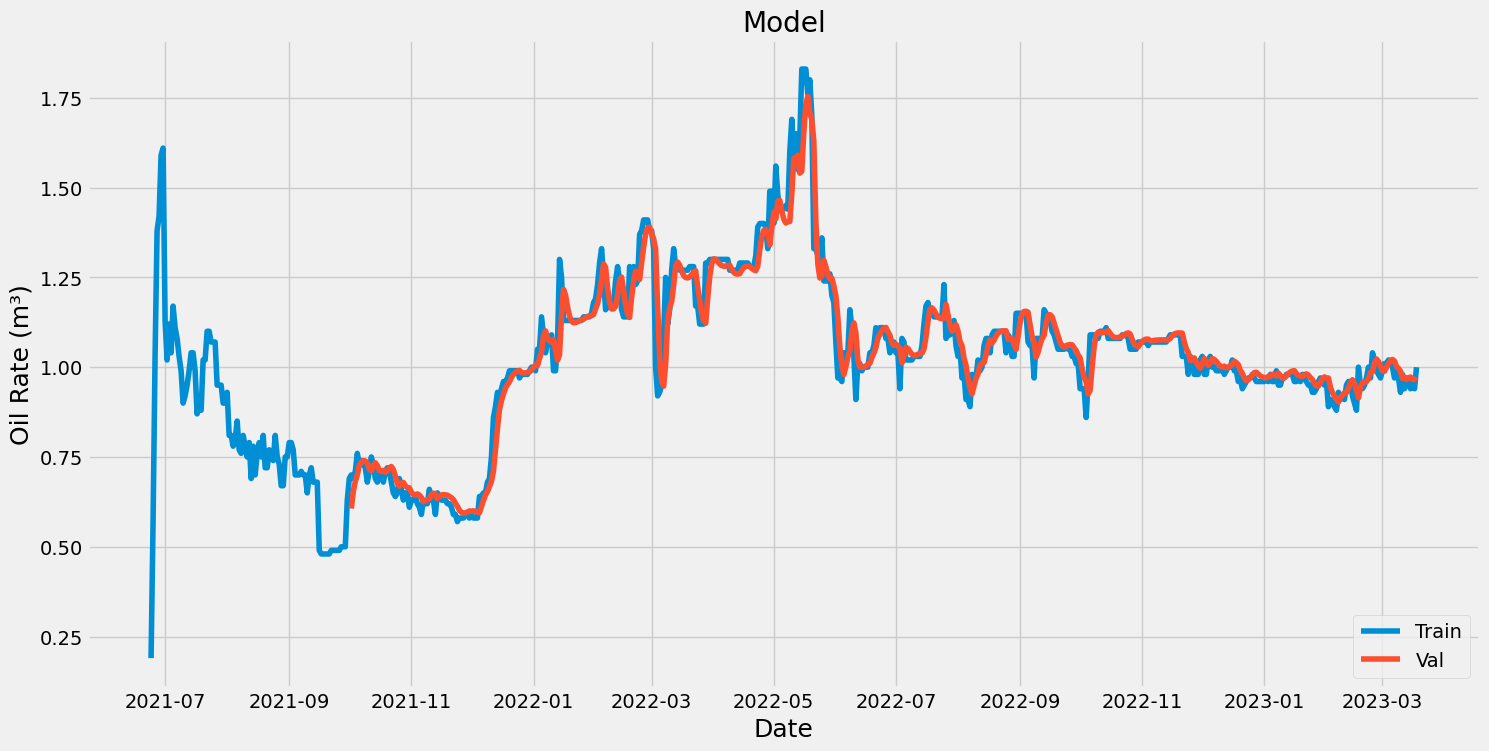

In [56]:
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Oil Rate (m³)', fontsize=18)
plt.plot(df['oil'])
plt.plot(df["prediction"])
plt.legend(['Train', 'Val', 'data_training'], loc='lower right')
plt.show()

In [57]:
output2 = pd.DataFrame(df)
output2.to_csv('rf.csv', index = None, encoding = "utf-8_sig", header = None)

In [58]:
x_train.shape

(407, 100, 1)

In [59]:
def add_remove(x,prediction):
    x = list(x)
    x[0] = list(x[0])
    x = [x[0][1:]]
    x[0].append(prediction)
    ar = np.asarray(x).astype(np.float32)
    return ar

In [60]:
reuslt = []
qq = a[-100:].reshape(1,100,1).astype(np.float32)
print(qq.shape)
period = 300
for i in range(period):
    temporary = model.predict(qq)
    reuslt.append(temporary)
    qq = add_remove(qq, temporary)

(1, 100, 1)


C:\Users\15966\AppData\Local\Temp\ipykernel_14856\1956507870.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asarray(x).astype(np.float32)


In [61]:
import random

In [62]:
output = []
for i in reuslt:
    a = float(i) + random.random()/50
    output.append(a)
output

[0.8946301917235551,
 0.8595868057581302,
 0.8171133485768357,
 0.7562007383154831,
 0.7317673982775448,
 0.701002756916016,
 0.6760477511290607,
 0.657163247600179,
 0.6418100844304896,
 0.6440266400539548,
 0.6346457024393081,
 0.6129626248149158,
 0.6123470475979078,
 0.60840262732013,
 0.6167600399375123,
 0.5997537847955309,
 0.6150997289316569,
 0.5941665182727303,
 0.6110923439033429,
 0.6085887664489682,
 0.6070661820524283,
 0.5899609015675187,
 0.6045424758739437,
 0.5944734401406452,
 0.5838653339993093,
 0.5948164836626177,
 0.5951779256557722,
 0.5836522203722653,
 0.5893466635651953,
 0.5848584773150395,
 0.5962082681719868,
 0.5961264003410456,
 0.6019460853767239,
 0.5939487026050504,
 0.5967487985602422,
 0.5876638653131534,
 0.5997093655163912,
 0.5914748667577625,
 0.5961931993350893,
 0.5983277474015389,
 0.5997289498262451,
 0.5946237365250068,
 0.5925690602397505,
 0.5939660910549119,
 0.6022491765334366,
 0.5957665347367483,
 0.6029699716524938,
 0.59870301461305

In [63]:
#output2 = pd.DataFrame(output)
#output2.to_csv('result_1.csv', index = None, encoding = "utf-8_sig", header = None)